In [1]:
import numpy as np
import random
import math
import os
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import pandas as pd
import glob
import torch
%matplotlib inline

from tqdm.notebook import tqdm
from math import sqrt
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor

Rated_Capacity = 1.1

# 1. 加载数据

In [2]:
def drop_outlier(array, count, bins):
    index = []
    range_ = np.arange(1, count, bins)
    for i in range_[:-1]:
        array_lim = array[i : i + bins]
        sigma = np.std(array_lim)
        mean = np.mean(array_lim)
        th_max, th_min = mean + sigma * 2, mean - sigma * 2
        idx = np.where((array_lim < th_max) & (array_lim > th_min))
        idx = idx[0] + i
        index.extend(list(idx))
    return np.array(index)


def build_instances(sequence, window_size):
    # sequence: list of capacity
    x, y = [], []
    for i in range(len(sequence) - window_size):
        features = sequence[i : i + window_size]
        target = sequence[i + window_size]

        x.append(features)
        y.append(target)

    return np.array(x).astype(np.float32), np.array(y).astype(np.float32)


# 留一评估：一组数据为测试集，其他所有数据全部拿来训练
def get_train_test(data_dict, name, window_size=8):
    data_sequence = data_dict[name]["capacity"]
    train_data, test_data = (
        data_sequence[: window_size + 1],
        data_sequence[window_size + 1 :],
    )
    train_x, train_y = build_instances(train_data, window_size)
    for k, v in data_dict.items():
        if k != name:
            data_x, data_y = build_instances(v["capacity"], window_size)
            train_x, train_y = np.r_[train_x, data_x], np.r_[train_y, data_y]

    return train_x, train_y, list(train_data), list(test_data)


def relative_error(y_test, y_predict, threshold):
    true_re, pred_re = len(y_test), 0
    for i in range(len(y_test) - 1):
        if y_test[i] <= threshold >= y_test[i + 1]:
            true_re = i - 1
            break
    for i in range(len(y_predict) - 1):
        if y_predict[i] <= threshold:
            pred_re = i - 1
            break
    return (
        abs(true_re - pred_re) / true_re if abs(true_re - pred_re) / true_re <= 1 else 1
    )


def evaluation(y_test, y_predict):
    mse = mean_squared_error(y_test, y_predict)
    rmse = sqrt(mean_squared_error(y_test, y_predict))
    return rmse


def setup_seed(seed):
    np.random.seed(seed)  # Numpy module.
    random.seed(seed)  # Python random module.
    os.environ["PYTHONHASHSEED"] = str(seed)  # 为了禁止hash随机化，使得实验可复现。
    torch.manual_seed(seed)  # 为CPU设置随机种子
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)  # 为当前GPU设置随机种子
        torch.cuda.manual_seed_all(
            seed
        )  # if you are using multi-GPU，为所有GPU设置随机种子
        torch.backends.cudnn.benchmark = False
        torch.backends.cudnn.deterministic = True

## 1.1 提取所需特征

In [3]:
Battery_list = ["CS2_35", "CS2_36", "CS2_37", "CS2_38"]

dir_path = "dataset/"
# Battery = {}
# for name in Battery_list:
#     print("Load Dataset " + name + " ...")
#     path = glob.glob(dir_path + name + "/*.xlsx")
#     dates = []
#     for p in path:
#         df = pd.read_excel(p, sheet_name=1)
#         print("Load " + str(p) + " ...")
#         dates.append(df["Date_Time"][0])
#     idx = np.argsort(dates)
#     path_sorted = np.array(path)[idx]

#     count = 0
#     discharge_capacities = []
#     health_indicator = []
#     internal_resistance = []
#     CCCT = []
#     CVCT = []
#     for p in path_sorted:
#         df = pd.read_excel(p, sheet_name=1)
#         print("Load " + str(p) + " ...")
#         cycles = list(set(df["Cycle_Index"]))
#         for c in cycles:
#             df_lim = df[df["Cycle_Index"] == c]
#             # Charging
#             df_c = df_lim[(df_lim["Step_Index"] == 2) | (df_lim["Step_Index"] == 4)]
#             c_v = df_c["Voltage(V)"]
#             c_c = df_c["Current(A)"]
#             c_t = df_c["Test_Time(s)"]
#             # CC or CV
#             df_cc = df_lim[df_lim["Step_Index"] == 2]
#             df_cv = df_lim[df_lim["Step_Index"] == 4]
#             CCCT.append(np.max(df_cc["Test_Time(s)"]) - np.min(df_cc["Test_Time(s)"]))
#             CVCT.append(np.max(df_cv["Test_Time(s)"]) - np.min(df_cv["Test_Time(s)"]))

#             # Discharging
#             df_d = df_lim[df_lim["Step_Index"] == 7]
#             d_v = df_d["Voltage(V)"]
#             d_c = df_d["Current(A)"]
#             d_t = df_d["Test_Time(s)"]
#             d_im = df_d["Internal_Resistance(Ohm)"]

#             if len(list(d_c)) != 0:
#                 time_diff = np.diff(list(d_t))
#                 d_c = np.array(list(d_c))[1:]
#                 discharge_capacity = time_diff * d_c / 3600  # Q = A*h
#                 discharge_capacity = [
#                     np.sum(discharge_capacity[:n])
#                     for n in range(discharge_capacity.shape[0])
#                 ]
#                 discharge_capacities.append(-1 * discharge_capacity[-1])

#                 dec = np.abs(np.array(d_v) - 3.8)[1:]
#                 start = np.array(discharge_capacity)[np.argmin(dec)]
#                 dec = np.abs(np.array(d_v) - 3.4)[1:]
#                 end = np.array(discharge_capacity)[np.argmin(dec)]
#                 health_indicator.append(-1 * (end - start))

#                 internal_resistance.append(np.mean(np.array(d_im)))
#                 count += 1

#     discharge_capacities = np.array(discharge_capacities)
#     health_indicator = np.array(health_indicator)
#     internal_resistance = np.array(internal_resistance)
#     CCCT = np.array(CCCT)
#     CVCT = np.array(CVCT)

#     idx = drop_outlier(discharge_capacities, count, 40)
#     df_result = pd.DataFrame(
#         {
#             "cycle": np.linspace(1, idx.shape[0], idx.shape[0]),
#             "capacity": discharge_capacities[idx],
#             "SoH": health_indicator[idx],
#             "resistance": internal_resistance[idx],
#             "CCCT": CCCT[idx],
#             "CVCT": CVCT[idx],
#         }
#     )
#     Battery[name] = df_result

**或者**

## 1.1 加载已经提取完成的数据

**如果上面的读取数据集失败，可以通过下面的方式加载已提取出来的数据**

In [4]:
Battery_list = ["CS2_35", "CS2_36", "CS2_37", "CS2_38"]
Battery = np.load("dataset/CALCE.npy", allow_pickle=True)
Battery = Battery.item()

## 1.2 画容量衰减曲线

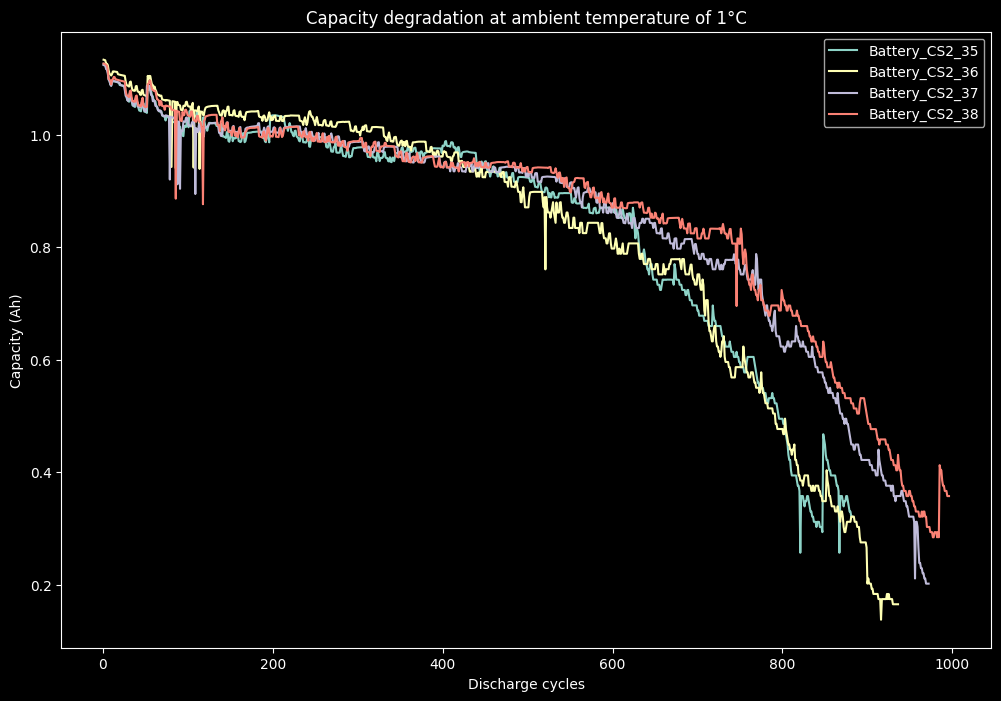

In [5]:
# Rated_Capacity = 1.1
fig, ax = plt.subplots(1, figsize=(12, 8))
for name in Battery_list:
    df_result = Battery[name]
    ax.plot(df_result["cycle"], df_result["capacity"], label="Battery_" + name)
ax.set(
    xlabel="Discharge cycles",
    ylabel="Capacity (Ah)",
    title="Capacity degradation at ambient temperature of 1°C",
)
plt.legend()

# 2. 建立模型及其训练

## 2.1 建立模型

In [6]:
def train_rf(
    feature_size,
    n_estimators=100,
    max_depth=None,
    random_state=0,
    epochs=100,
    metric="rmse",
):
    score_list, result_list = [], []
    setup_seed(random_state)

    for i in range(4):
        name = Battery_list[i]
        train_x, train_y, train_data, test_data = get_train_test(
            Battery, name, feature_size
        )
        test_sequence = train_data + test_data
        test_x, test_y = build_instances(test_sequence, feature_size)

        # Create and train RandomForest model
        model = RandomForestRegressor(
            n_estimators=n_estimators,
            max_depth=max_depth,
            random_state=random_state,
        )

        # Training the RandomForest model
        model.fit(train_x, train_y)

        # Predicting and evaluating performance
        y_pred = model.predict(test_x)
        
        rmse = evaluation(y_test=test_y, y_predict=y_pred)
        score_list.append(rmse)

        result_list.append(train_data.copy()[:-1] + list(y_pred))

    return score_list, result_list

## 2.2 训练

In [7]:
# Set up Random Forest training parameters
feature_size = 64
epochs = 100
n_estimators = 100  # Number of trees in the forest
max_depth = 10  # Maximum depth of the trees
metric = "rmse"

SCORE = []
for seed in tqdm(range(4)):
    print("seed: ", seed)
    score_list, _ = train_rf(
        feature_size=feature_size,
        n_estimators=n_estimators,
        max_depth=max_depth,
        random_state=seed,
        metric=metric,
    )
    print(np.array(score_list))
    print(metric + ": for this seed: {:<6.4f}".format(np.mean(np.array(score_list))))
    for s in score_list:
        SCORE.append(s)
    print("------------------------------------------------------------------")
print(metric + ": mean: {:<6.4f}".format(np.mean(np.array(SCORE))))

  0%|          | 0/4 [00:00<?, ?it/s]

seed:  0
[0.0136047  0.0182402  0.01200539 0.01363871]
rmse: for this seed: 0.0144
------------------------------------------------------------------
seed:  1
[0.01338514 0.01766301 0.01192661 0.01387198]
rmse: for this seed: 0.0142
------------------------------------------------------------------
seed:  2
[0.01357701 0.01718316 0.01228281 0.01368913]
rmse: for this seed: 0.0142
------------------------------------------------------------------
seed:  3
[0.01364706 0.01747582 0.01182322 0.01426126]
rmse: for this seed: 0.0143
------------------------------------------------------------------
rmse: mean: 0.0143


## 2.4 画预测曲线

**从上面的种子中选择一个表现最好的种子**

seed:  2
[0.01357701 0.01718316 0.01228281 0.01368913]
rmse for this seed: 0.0142


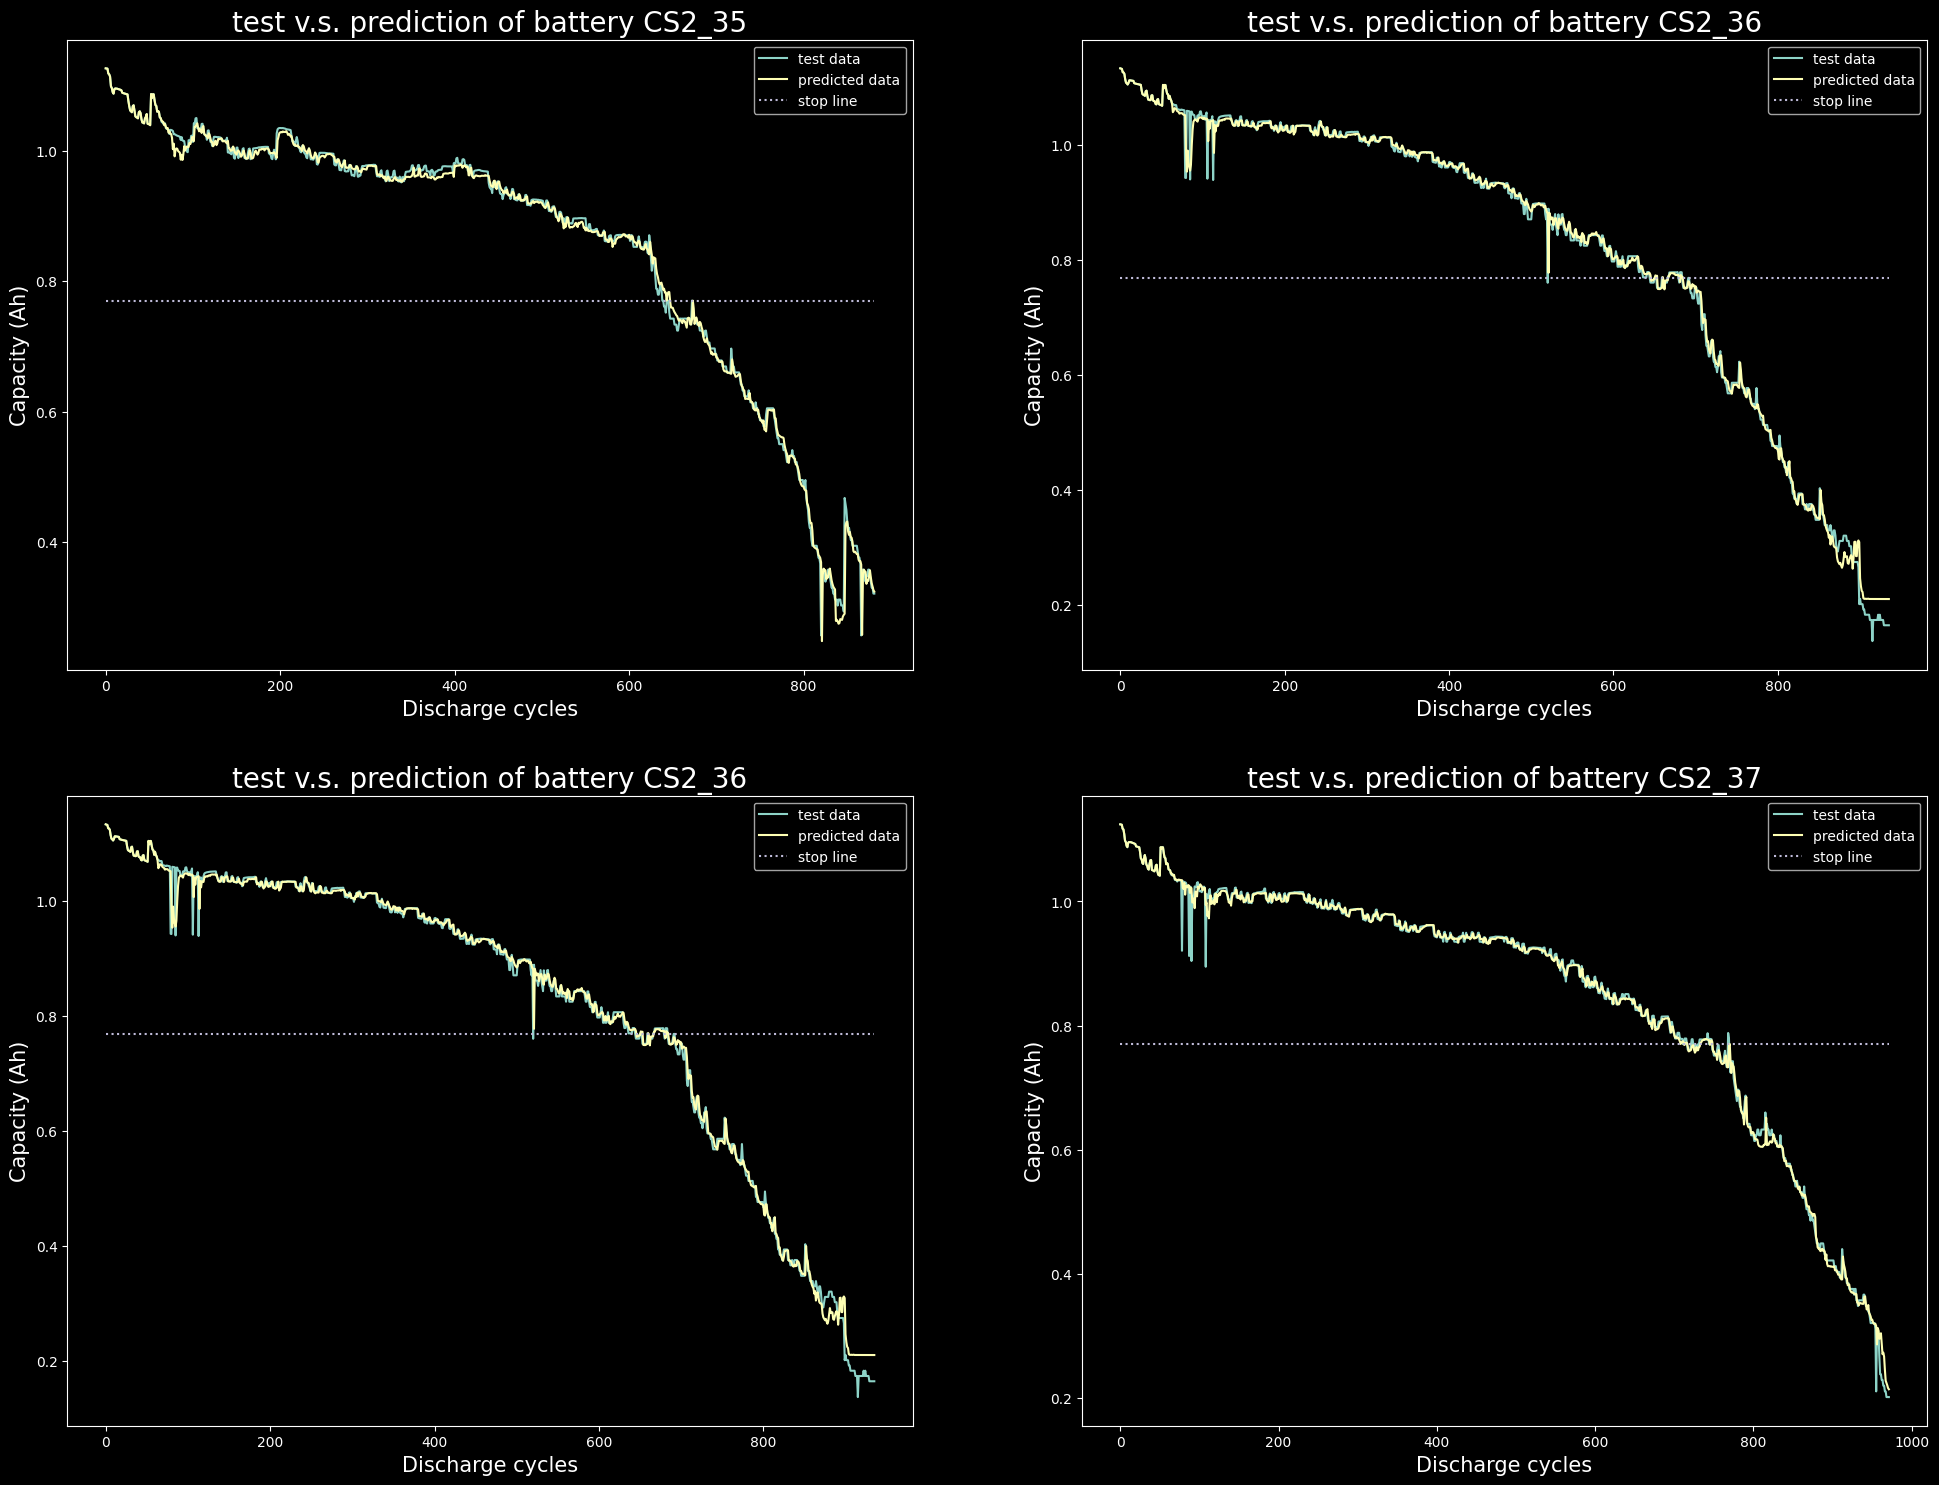

In [10]:
seed = 2

SCORE = []
print("seed: ", seed)
score_list, prediction_list = train_rf(
    feature_size=feature_size,
    n_estimators=n_estimators,
    max_depth=max_depth,
    random_state=seed,
    metric=metric,
)

print(np.array(score_list))
print(metric + " for this seed: {:<6.4f}".format(np.mean(np.array(score_list))))

fig, ax = plt.subplots(2, 2, figsize=(24, 18))

for i in range(2):
    for j in range(2):
        t = i + j
        battery_name = Battery_list[t]
        test_data = Battery[battery_name]["capacity"]
        predict_data = prediction_list[t]
        x = [t for t in range(len(test_data))]
        threshold = [Rated_Capacity * 0.7] * len(test_data)
        ax[i][j].plot(x, test_data, label="test data")
        ax[i][j].plot(x, predict_data, label="predicted data")
        ax[i][j].plot(x, threshold, ls=":", label="stop line")
        ax[i][j].legend()
        ax[i][j].set_xlabel("Discharge cycles", fontsize=15)
        ax[i][j].set_ylabel("Capacity (Ah)", fontsize=15)
        ax[i][j].set_title(
            "test v.s. prediction of battery " + battery_name, fontsize=20
        )
plt.show()
